## Cell Model Training

Primary notebook for cell counting efforts that involves 3 primary steps:

1. Select training, validation and un-annotated data
2. Train model and freeze weights in persisted location
3. Load model and apply to un-annotated data

In [1]:
import os
import os.path as osp
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celldom
from mrcnn import visualize as mrcnn_viz
from mrcnn import model as mrcnn_model_lib
from imgaug import augmenters as iaa
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn import model as mrcnn_model
from cvutils.mrcnn.session import init_keras_session
from celldom.dataset import cell_dataset
from celldom.dataset import utils as dataset_utils
from celldom.config import cell_config
from celldom.warnings import disable_mrcnn_warnings
from celldom import seed
init_keras_session()
disable_mrcnn_warnings()

dataset_dirs = {
    'dataset03': osp.join(celldom.get_dataset_dir(), 'dataset03', 'ApartmentTraining'),
    'dataset02': osp.join(celldom.get_dataset_dir(), 'dataset02')
}
model_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.6', 'cell_model')
model_path = osp.join(model_dir, 'cell_model.h5')
export_dir = 'results'

# Initialize output directories
os.makedirs(export_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

Using TensorFlow backend.


### Data Partitioning

In [2]:
# Determine all available images for training
data_files = pd.concat([
    dataset_utils.get_data_files(v, patterns=['*.jpeg', '*.jpg']).assign(dataset=k)
    for k, v in dataset_dirs.items()
])
data_files = data_files.reset_index(drop=True)

In [3]:
data_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6916 entries, 0 to 6915
Data columns (total 5 columns):
image_name      6916 non-null object
image_path      6916 non-null object
annot_path      6916 non-null object
annot_exists    6916 non-null bool
dataset         6916 non-null object
dtypes: bool(1), object(4)
memory usage: 223.0+ KB


In [4]:
data_files.groupby(['dataset', 'annot_exists']).size()

dataset    annot_exists
dataset02  False            664
           True             160
dataset03  False           5412
           True             680
dtype: int64

In [5]:
# Ensure there are no duplicate image entries
if len(data_files) > 0:
    assert data_files['image_name'].value_counts().max() == 1

print(
    'Number of images total = {}, number annotated = {}'
    .format(len(data_files), data_files.annot_exists.sum())
)
data_files.head(3)

Number of images total = 6916, number annotated = 840


,image_name,image_path,annot_path,annot_exists,dataset
0,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,dataset03
1,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,dataset03
2,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,dataset03


In [6]:
# Compute summary statistics about images to help determine the status of each
data_files = cell_dataset.quantify_data_files(data_files, cell_config.CLASS_NAMES)
data_files[data_files.annot_exists].head()

,annot_exists,annot_path,ct:cell,dataset,image_name,image_path,pct:cell_to_cellclump
0,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
1,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
2,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
3,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN
4,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,1.0,dataset03,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,NaN


In [8]:
data_files['pct:cell_to_cellclump'].describe()

count    144.000000
mean       0.950697
std        0.111018
min        0.148410
25%        0.942364
50%        0.969786
75%        1.000000
max        1.000000
Name: pct:cell_to_cellclump, dtype: float64

In [7]:
data_files.groupby('dataset')['ct:cell'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
dataset02,160.0,25.181250,35.800262,0.0,2.0,11.0,34.0,201.0
dataset03,680.0,6.176471,9.184480,1.0,3.0,4.0,5.0,70.0


In [8]:
data_files['ct:cell'].describe()

count    840.000000
mean       9.796429
std       19.155041
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max      201.000000
Name: ct:cell, dtype: float64

In [13]:
# Set any exclusion reasons, if applicable (currently there are none other than the existence of annotations)
PCT_CELL_TO_CELLCLUMP_THRESH = .9

def get_exclusion_reason(r):
    if not r['annot_exists']:
        return 'No Annotations'
    if not pd.isnull(r['pct:cell_to_cellclump']) and r['pct:cell_to_cellclump'] < PCT_CELL_TO_CELLCLUMP_THRESH:
        return 'Cell to Clump Ratio < {}'.format(PCT_CELL_TO_CELLCLUMP_THRESH)
    return None
    
#data_files['exclusion'] = np.where(data_files['annot_exists'], None, 'No Annotations')
data_files['exclusion'] = data_files.apply(get_exclusion_reason, axis=1)
data_files['exclusion'].fillna('None').value_counts()

No Annotations               6076
None                          829
Cell to Clump Ratio < 0.9      11
Name: exclusion, dtype: int64

In [14]:
MODELING_MAX_SAMPLES = len(data_files)
TRAINING_FRACTION = .8

# Determine index corresponding to first MODELING_MAX_SAMPLES records eligible for model (as training or validation records)
idx_modeling = data_files[data_files.exclusion.isnull()].head(MODELING_MAX_SAMPLES).index.values

# Split index into training and validation 
idx_train = pd.Series(idx_modeling).sample(frac=TRAINING_FRACTION, random_state=seed).values
idx_val = np.setdiff1d(idx_modeling, idx_train)

data_files['group'] = 'external'
data_files.loc[idx_train, 'group'] = 'training'
data_files.loc[idx_val, 'group'] = 'validation'

# Summarize and verify counts by training record group
grp_ct = data_files['group'].value_counts()
assert grp_ct['training'] + grp_ct['validation'] == data_files.exclusion.isnull().sum()
assert grp_ct['external'] == data_files.exclusion.notnull().sum()
data_files['group'].value_counts()

external      6087
training       663
validation     166
Name: group, dtype: int64

In [15]:
#'{address}-{cohort}-{ry:02d}-{rx:02d}-{date}-{z}-{my:04d}-{mx:04d}-{patch_idx:02d}.jpeg'
#data_files['image_name'].iloc[0]

In [16]:
data_files.groupby('group')['ct:cell'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
external,11.0,22.363636,23.234770,2.0,8.5,19.0,24.0,86.0
training,663.0,9.859729,20.010947,0.0,3.0,4.0,5.0,201.0
validation,166.0,8.710843,14.651119,0.0,3.0,4.0,6.0,101.0


In [17]:
# Save record of data file categorization for later reference
path = osp.join(export_dir, 'data_files.csv')
data_files.to_csv(path, index=False)
'Data file metadata saved to path {}'.format(path)

'Data file metadata saved to path results/data_files.csv'

## Training

Based on the file categorization above, this section will use all available training + validation data to build a segmentation model:

In [18]:
# Training dataset
train_image_paths = data_files.groupby('group').get_group('training')['image_path'].values
dataset_train = cell_dataset.CellDataset()
dataset_train.initialize(train_image_paths)
dataset_train.prepare()

# # Validation dataset
val_image_paths = data_files.groupby('group').get_group('validation')['image_path'].values
dataset_val = cell_dataset.CellDataset()
dataset_val.initialize(val_image_paths)
dataset_val.prepare()

'Num training images = {}, num validation images = {}'.format(len(train_image_paths), len(val_image_paths))

'Num training images = 663, num validation images = 166'

In [19]:
# Fetch RCNN training configuration
train_config = cell_config.CellTrainingConfig()

# # Set these step counts to equal data size so that a single epoch is easier to describe
# train_config.STEPS_PER_EPOCH = len(train_image_paths)
# train_config.VALIDATION_STEPS = len(val_image_paths)

train_config.STEPS_PER_EPOCH = 50
train_config.VALIDATION_STEPS = 25
    
# Manually set gpu/batch size params
train_config.IMAGES_PER_GPU = 8
train_config.GPU_COUNT = 1
# see: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py
train_config.BATCH_SIZE = train_config.IMAGES_PER_GPU * train_config.GPU_COUNT

train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [20]:
# Define train-time augmentation
augmentation = iaa.Sequential([
    iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.CropAndPad((0, 5)),
        iaa.Multiply((0.8, 1.2)),
        iaa.ContrastNormalization((0.5, 2.0)),
        iaa.GaussianBlur(sigma=(0.0, .5))
    ]),
    iaa.Sometimes(0.9, iaa.Affine(
        rotate=(-10, 10),
        scale=(.9, 1.1)
    ))
])

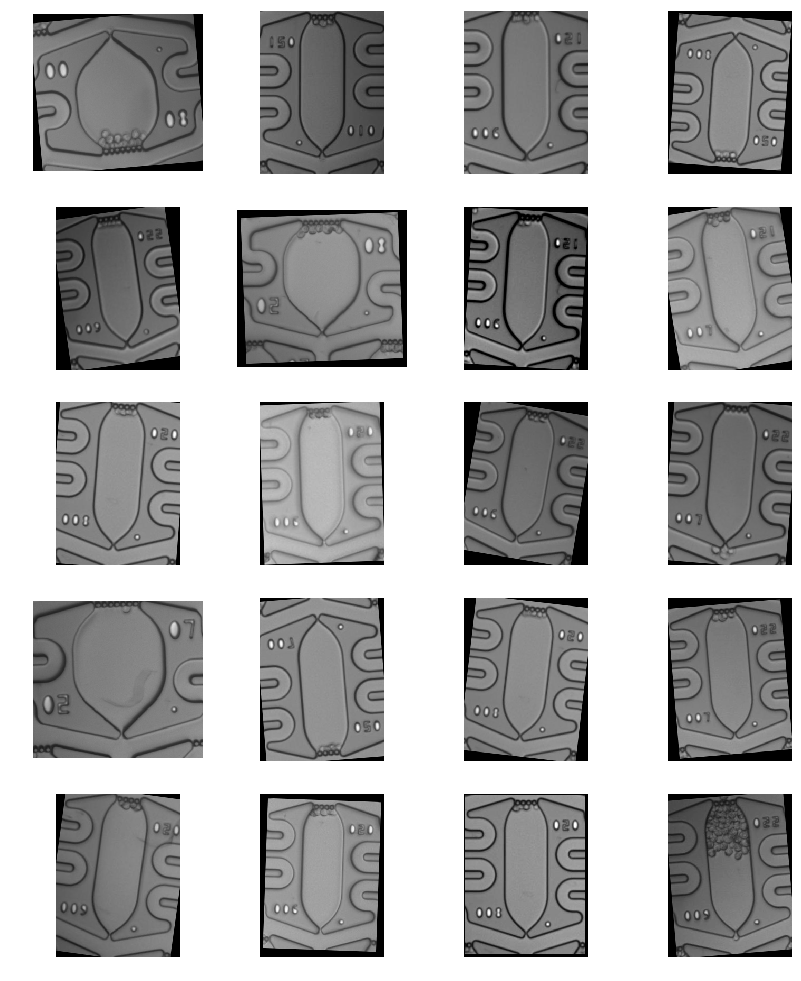

In [21]:
# Show example augmentations
mrcnn_viz.display_images([
    augmentation.augment_image(dataset_train.load_image(i))
    for i in np.random.choice(np.arange(len(dataset_train.image_ids)), size=20, replace=False)
])

In [22]:
# Initialize model from COCO weights (change to "last" to restart from last training run)
model = mrcnn_model.get_model(
    mode="training", config=train_config, 
    model_dir=model_dir, init_with='coco'
)

In [23]:
import wandb
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/a1e80qsv
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/a1e80qsv

In [ ]:
%%time
from wandb.keras import WandbCallback

with wandb.monitor(display=False):
    # Run training for small number of epochs (takes about 1 min per epoch on this dataset)
    model.train(
        dataset_train, dataset_val, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=20, 
        layers='heads',
        custom_callbacks=[WandbCallback(save_model=False)],
        augmentation=augmentation
    )
    
    # Fine tune rest of network
    model.train(
        dataset_train, dataset_val, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=40, 
        layers='all',
        custom_callbacks=[WandbCallback(save_model=False)],
        augmentation=augmentation
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/a1e80qsv


- Check tensorboard
- Pick epoch to use moving forward and copy to results dir

In [222]:
!find $model_dir/* | sort | tail -n 10

/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0191.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0192.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0193.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0194.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0195.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0196.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0197.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0198.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0199.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0200.h5


In [224]:
!cp /lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0199.h5 $model_path
'Final model copied to result path "{}"'.format(model_path)

'Final model copied to result path "/lab/data/celldom/model/r0.3/cell_model/cell_model.h5"'

## Check Validation Predictions

In [226]:
from cvutils.mrcnn import inference as mrcnn_inference

# Re-initialize model from exported weights in inference mode
inference_config = cell_config.CellInferenceConfig()
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

In [229]:
import imp
imp.reload(mrcnn_inference)

<module 'cvutils.mrcnn.inference' from '/lab/repos/cvutils/python/cvutils/mrcnn/inference.py'>

In [230]:
# Generate prediction comparisons
pred_gen = mrcnn_inference.prediction_generator(model, dataset_val)

In [231]:
preds = list(pred_gen)

In [232]:
len(preds)

136

In [237]:
pred = preds[75]

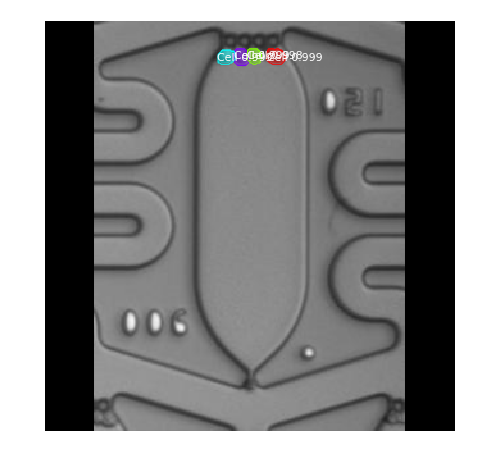

In [238]:
mrcnn_viz.display_instances(
    pred.image, pred.pred_rois, pred.pred_masks, pred.pred_class_ids, 
    dataset_val.class_names, pred.pred_scores, show_bbox=False, figsize=(8, 8))

### External Validation

In [239]:
# External dataset
ext_image_paths = data_files.groupby('group').get_group('external')['image_path'].values
dataset_ext = cell_dataset.CellDataset()
dataset_ext.initialize(ext_image_paths)
dataset_ext.prepare()

In [240]:
pd.set_option('display.max_colwidth', 1000)
df_ext = pd.DataFrame(dict(path=ext_image_paths, idx=np.arange(len(ext_image_paths))))
df_ext[df_ext['path'].str.contains('NoDrug')].head()

,idx,path
14,14,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-z_0-0261-0340-10.jpeg
15,15,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm3-0261-0339-11.jpeg
16,16,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm6-0262-0339-11.jpeg
17,17,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm9-0262-0339-09.jpeg
18,18,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zp3-0261-0339-08.jpeg


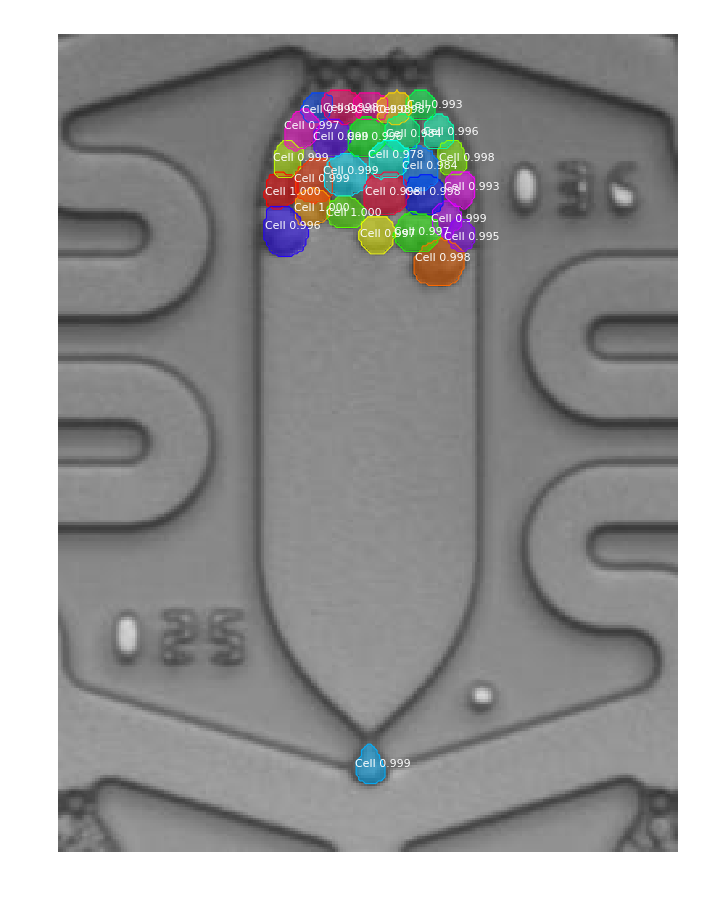

In [273]:
image_id = np.random.choice(dataset_ext.image_ids, size=1)[0]
image = dataset_ext.load_image(image_id)
r = model.detect([image])[0]
mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_ext.class_names, r['scores'], show_bbox=False)